In [1]:
import os

import json
import torch
import numpy as np
import matplotlib
matplotlib.use('Agg')  # Use the 'Agg' backend
import matplotlib.pyplot as plt
from PIL import Image
import sys
import random
from datetime import datetime
from typing import Any, Dict, List, Optional, Tuple
import math
import copy
from tqdm import tqdm

## SAM2 images
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2_video_predictor
import cv2
import argparse

# Grounding Dino APIs
from groundingdino.util.inference import Model as gd_Model
from groundingdino.util.inference import load_image as load_gd_image
from groundingdino.util.utils import get_phrases_from_posmap

from laser.preprocess.mask_generation_grounding_dino import generate_masks_grounding_dino, get_frames, vidwrite 
from laser.preprocess.mask_generation import gen_video_masks
from laser.loading import load_video


* 'schema_extra' has been renamed to 'json_schema_extra'


In [2]:
%matplotlib notebook
%matplotlib inline 

In [3]:
data_dir = os.path.abspath(os.path.join(os.path.abspath("__file__"), "../../data"))
assert os.path.exists(data_dir), f"Data directory {data_dir} does not exist."

home_dir = os.path.expanduser("~")
sam_dir = os.path.join(home_dir, "research/sam2")
sam_checkpoint_dir = os.path.join(sam_dir, "checkpoints")
sam_config_dir = os.path.join(data_dir, "sam2/configs")

gd_dir = os.path.join(home_dir, "research/GroundingDINO")
gd_checkpoint_dir = os.path.join(gd_dir, "checkpoints")
gd_config_dir = os.path.join(gd_dir, "groundingdino/config")

assert os.path.exists(gd_dir)
assert os.path.exists(sam_checkpoint_dir)
assert os.path.exists(sam_config_dir)
assert os.path.exists(gd_checkpoint_dir)
assert os.path.exists(gd_config_dir)

print(sam_dir)
##### load grounding dino #####
GROUNDING_DINO_CONFIG = os.path.join(gd_config_dir, "GroundingDINO_SwinT_OGC.py") 
GROUNDING_DINO_CHECKPOINT = os.path.join(gd_checkpoint_dir, "groundingdino_swint_ogc.pth")
assert os.path.exists(GROUNDING_DINO_CONFIG)
assert os.path.exists(GROUNDING_DINO_CHECKPOINT)

BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
device = "cuda:0"

grounding_model = gd_Model(
    model_config_path=GROUNDING_DINO_CONFIG, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=device
)

##### load Sam2 #####
checkpoint_path = os.path.join(sam_checkpoint_dir, "sam2.1_hiera_base_plus.pt")
config_path = os.path.join("configs/sam2.1/sam2.1_hiera_b+.yaml") 

sam2 = build_sam2(config_path, checkpoint_path, device=device, apply_postprocessing=False)
sam_target_fps = 1
prompt_only = True

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    points_per_batch=32,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.8,
    crop_n_layers=2,
    box_nms_thresh=0.6,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=30.0,
    use_m2m=True,
)


/home/jianih/research/sam2


final text_encoder_type: bert-base-uncased


## Demo Video Loader

In [4]:
# This is for data loading
demo_dir = os.path.abspath(os.path.join(os.path.abspath("__file__"), ".."))
video_dir = os.path.abspath(os.path.join(demo_dir, "videos"))
bounding_box_dir = os.path.join(demo_dir, 'video_bboxes')
mask_dir = os.path.join(demo_dir, 'video_masks')
new_video_dir = os.path.join(demo_dir, 'new_videos')


In [5]:
#### Load specific video to check
video_id = 'v1'
target_fps = 1

video_path = os.path.join(video_dir, video_id+".mp4")
video_tensor = load_video(video_path, target_fps=target_fps)

new_video_name = f"{video_id}.mp4"
new_video_path = os.path.join(new_video_dir, new_video_name)

if not os.path.exists(new_video_path):
    vidwrite(new_video_path, video_tensor, framerate=target_fps, vcodec='libx264')
    
classes=['human', 'dog', 'freesbie']
CHUNK = 5  # Set your desired chunk size
classes_ls = [classes[i:i + CHUNK] for i in range(0, len(classes), CHUNK)]

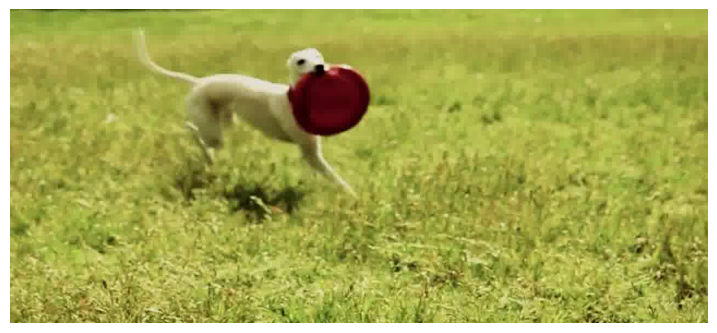

In [6]:
# take a look the first video frame
frame_idx = 1
frame = video_tensor[frame_idx]

plt.figure(figsize=(9, 6))
plt.axis("off")
plt.imshow(frame)
plt.show()

## SAM2 Generated Masks

In [7]:
from vis_utils import get_mask_one_image

# This line is necessary to avoid werid bug 
height, width, _ = frame.shape
masks = mask_generator.generate(frame)
masks = [m['segmentation'].reshape(height, width, 1) for m in masks]

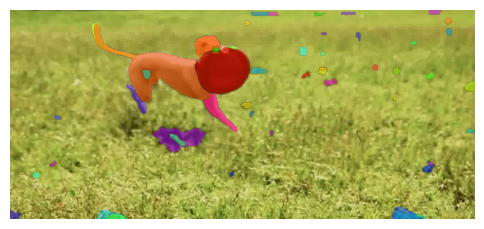

In [8]:
fig, ax = get_mask_one_image(frame, masks)

## Grounding Dino + SAM2 Masks

In [9]:
from laser.preprocess.mask_generation_grounding_dino import gd_predict_batched
box_threshold = 0.20
text_threshold = 0.15
frame = video_tensor[0]
with torch.amp.autocast('cuda', enabled=False):
    all_dets = gd_predict_batched(grounding_model, frame, classes_ls, box_threshold, text_threshold)


In [10]:
from laser.preprocess.mask_generation_grounding_dino import post_process_detections, get_valid_bbox_val
from vis_utils import get_mask_one_image

# This line is necessary to avoid werid bug 
height, width, _ = frame.shape

predictor = build_sam2_video_predictor(config_path, checkpoint_path, device=device)

inference_state = predictor.init_state(video_path=video_path, target_fps=None)

detections = post_process_detections(all_dets, classes_ls)
bboxes = torch.tensor([(get_valid_bbox_val(x1, width), 
                get_valid_bbox_val(y1, height),
                get_valid_bbox_val(x2, width), 
                get_valid_bbox_val(y2, height))
                for x1, y1, x2, y2 in detections.xyxy])
pred_class_ls = detections.class_names

current_obj_id = 0
masks = {}
oid_class_pred = {}
for bbox_id, (bbox, pred_class) in enumerate(zip(bboxes, pred_class_ls)):
    current_obj_id += 1
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=frame_idx,
        obj_id = current_obj_id,
        box=bbox,
    )
    mask_idx = out_obj_ids.index(current_obj_id)
    new_mask = (out_mask_logits[mask_idx] > 0).cpu()
    assert torch.sum(new_mask) > 0
    masks[current_obj_id] = new_mask.permute(1,2,0)
    oid_class_pred[current_obj_id] = pred_class


(<Figure size 600x600 with 1 Axes>, <Axes: >)

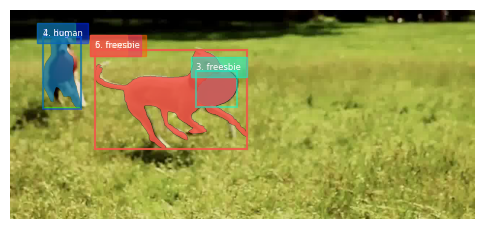

In [11]:
get_mask_one_image(frame, masks, oid_class_pred=oid_class_pred)

## How to use LASER

In [12]:
from laser.models import llava_clip_model_v3
import os
import torch

data_dir = os.path.abspath(os.path.join(os.path.abspath("__file__"), "../../data"))
model_dir = os.path.abspath(os.path.join(data_dir, f"LLaVA-Video-178K-v2/models/ensemble-02-10"))
model_name = "ensemble-2025-02-10-14-57-22"
epoch = 0

def load_model(model_dir, model_name, epoch, device):
    model_name = model_name + f'.{epoch}.model'
    predicate_model = torch.load(os.path.join(model_dir, model_name), map_location=device, weights_only=False)
    return predicate_model

device = "cuda" if torch.cuda.is_available() else "cpu"  # Automatically use GPU if available
predicate_model = load_model(model_dir, model_name, epoch, device)

In [17]:
from laser.preprocess.mask_generation_grounding_dino import mask_to_bbox

def reformat_video_segments(vid, segments, bbox_min_dim=5):
    batched_object_ids = []
    batched_pred_masks = []
    batched_pred_bboxes = []
    frame_object_pairs = []
    
    for fid, frame_info in segments.items():
        valid_objs = []
        for oid, o_mask in frame_info.items():
            if type(o_mask) == torch.Tensor:
                o_mask = o_mask.permute(1, 2, 0).numpy()
            else: 
                o_mask = o_mask.transpose(1, 2, 0)
                
            if o_mask.any():
                bbox = mask_to_bbox(o_mask)
            else:
                bbox = None
                
            # print(bbox)
            if not bbox is None:
                # print(bbox)
                x_min, y_min, x_max, y_max = bbox
                if abs(y_max - y_min) < bbox_min_dim or abs(x_max - x_min) < bbox_min_dim:
                    continue
                valid_objs.append(oid)
                batched_object_ids.append((vid, fid, oid))
                batched_pred_masks.append(o_mask)
                batched_pred_bboxes.append(bbox)
                
        for i in valid_objs:
            for j in valid_objs:
                if not i==j:
                    frame_object_pairs.append((vid, fid, (i, j)))
            
    return batched_object_ids, batched_pred_masks, batched_pred_bboxes, frame_object_pairs
            
            

In [14]:
with torch.amp.autocast('cuda', enabled=False):
    video_segments, oid_class_pred, suc = generate_masks_grounding_dino(
        grounding_model,
        box_threshold,
        text_threshold,
        predictor, 
        mask_generator, 
        video_tensor, 
        new_video_path,
        video_id,
        out_dir=bounding_box_dir, 
        classes_ls=classes_ls,
        target_fps=None,
        visualize=False,
        frames=None,
        max_prop_time=10) 

Start detecting objects at time  15:16:51.282345


Detecting objects: 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


Finished detecting objects at time  15:16:51.687011
Loading inference state at time  15:16:51.687051
Number of frames:  3
None


Processing frames: 100%|██████████| 3/3 [00:00<00:00, 21.01it/s]


Annotated frames:  []
Find the most dense prompt at time  15:16:52.019229
Most dense frame: 1


Start propagating objects at time  15:16:52.021502
Pass count:  0


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 23.31it/s]


Most dense frame: 0


Pass count:  1


propagate in video: 100%|██████████| 3/3 [00:00<00:00, 15.17it/s]
propagate in video: 0it [00:00, ?it/s]


Most dense frame: 2


Pass count:  2


propagate in video: 100%|██████████| 3/3 [00:00<00:00, 20.96it/s]
propagate in video: 0it [00:00, ?it/s]

Most dense frame: -1




In [19]:
import importlib
import laser.preprocess.mask_generation_grounding_dino

importlib.reload(laser.preprocess.mask_generation_grounding_dino)
from laser.preprocess.mask_generation_grounding_dino import mask_to_bbox

vid = 0
sampled_frames = [0, 1, 2]

batched_video_ids = [vid]
batched_reshaped_raw_videos = [video_tensor[fid] for fid in sampled_frames]
sampled_segments = {fid:video_segments[fid] for fid in sampled_frames}
batched_object_ids, batched_pred_masks, batched_pred_bboxes, batched_object_pairs = reformat_video_segments(vid, sampled_segments)

## Visualization for Unary Predictions

In [20]:
predicate_model.clip_tokenizer.pad_token_id = 0

In [21]:
predicate_model.clip_tokenizer.pad_token = "<|endoftext|>"

In [25]:
batched_image_cate_probs, batched_image_unary_probs, batched_image_binary_probs, dummy_prob = \
    predicate_model(
        batched_video_ids=batched_video_ids,
        batched_videos=batched_reshaped_raw_videos,
        batched_masks=batched_pred_masks,  # batched_object_ids * video_height * video_width
        batched_bboxes=batched_pred_bboxes,  # batched_object_ids * dict<bboxes>
        batched_names=[classes],  # Dataset-wise categorical labels
        batched_object_ids=batched_object_ids,  # [video_id, frame_id, object_id]
        batched_unary_kws=[[]],  # Dataset-wise unary predicate labels
        batched_binary_kws=[[]],  # Dataset-wise binary predicate labels
        batched_obj_pairs=[],  # Ground truth binary relations
        batched_video_splits=[0],  # [number of videos]
        batched_binary_predicates=[None],  # None indicates inference time
    )

In [26]:
batched_image_cate_probs

{0: {(0, 'human'): tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>),
  (0, 'dog'): tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>),
  (0, 'freesbie'): tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>),
  (1, 'human'): tensor(0.1558, device='cuda:0', grad_fn=<MeanBackward0>),
  (1, 'dog'): tensor(0.8422, device='cuda:0', grad_fn=<MeanBackward0>),
  (1, 'freesbie'): tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>),
  (2, 'human'): tensor(0.1250, device='cuda:0', grad_fn=<MeanBackward0>),
  (2, 'dog'): tensor(0.3577, device='cuda:0', grad_fn=<MeanBackward0>),
  (2, 'freesbie'): tensor(0.5173, device='cuda:0', grad_fn=<MeanBackward0>),
  (3, 'human'): tensor(0.0798, device='cuda:0', grad_fn=<MeanBackward0>),
  (3, 'dog'): tensor(0.6544, device='cuda:0', grad_fn=<MeanBackward0>),
  (3, 'freesbie'): tensor(0.2658, device='cuda:0', grad_fn=<MeanBackward0>),
  (4, 'human'): tensor(0.4666, device='cuda:0', grad_fn=<MeanBackward0>),
  (4, 'dog'): tensor(0.5288, de

In [27]:
def format_cate_probs(batched_cate_probs, topk=3):
    new_batched_cate_probs = {}
    for vid, vid_pred in batched_cate_probs.items():
        new_batched_cate_probs[vid] = {}
        sorted_obj_preds = {}
        for (oid, cate), prob in vid_pred.items():
            if not oid in sorted_obj_preds:
                sorted_obj_preds[oid] = []
            sorted_obj_preds[oid].append((prob, cate))
        
        for oid in sorted_obj_preds:
            top_preds = sorted(sorted_obj_preds[oid], reverse=True)[:topk]
            str_info = []
            for (prob, cate) in top_preds:
                str_info.append(f"{prob:.2f}::{cate}")
            top_str = '\n'.join(str_info)
            new_batched_cate_probs[vid][oid] = top_str
        
    return new_batched_cate_probs

topk=3
formatted_batched_cate_probs = format_cate_probs(batched_image_cate_probs, topk)

In [32]:
formatted_batched_cate_probs

{0: {0: '1.00::dog\n0.00::freesbie\n0.00::human',
  1: '0.84::dog\n0.16::human\n0.00::freesbie',
  2: '0.52::freesbie\n0.36::dog\n0.13::human',
  3: '0.65::dog\n0.27::freesbie\n0.08::human',
  4: '0.53::dog\n0.47::human\n0.00::freesbie',
  5: '1.00::dog\n0.00::human\n0.00::freesbie',
  6: '1.00::dog\n0.00::human\n0.00::freesbie'}}

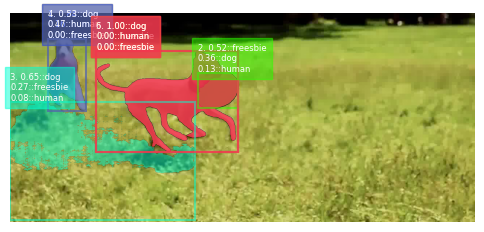

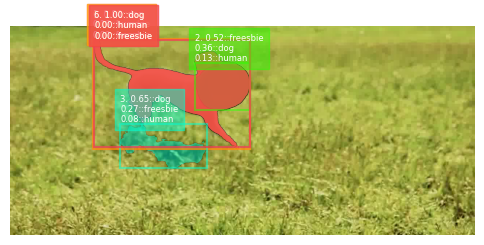

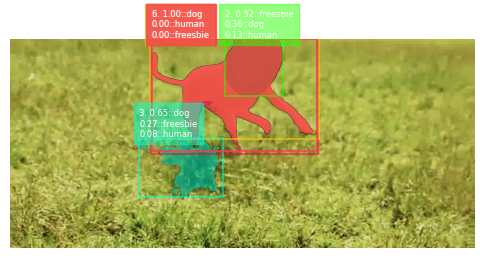

In [57]:
import importlib
import vis_utils

importlib.reload(vis_utils)
from vis_utils import get_video_masks_visualization
video_save_base_dir = os.path.join(data_dir, 'visualization/notebook')

get_video_masks_visualization(batched_reshaped_raw_videos, 
                              video_segments, 
                              video_id, 
                              video_save_base_dir, 
                              oid_class_pred=formatted_batched_cate_probs[0], 
                              sample_rate = 1)

## Visualization for Binary Predictions

In [42]:
from collections import defaultdict

def extract_valid_object_pairs(batched_object_ids, interested_object_pairs):
    """
    Extracts valid object pairs from batched object data.
    
    :param batched_object_ids: List of tuples (vid_id, frame_id, object_id)
    :param interested_object_pairs: List of tuples (from_object_id, to_object_id)
    :return: List of tuples (vid_id, frame_id, (from_object_id, to_object_id))
    """
    # Group object IDs by (vid_id, frame_id)
    frame_to_objects = defaultdict(set)
    for vid_id, frame_id, obj_id in batched_object_ids:
        frame_to_objects[(vid_id, frame_id)].add(obj_id)
    
    # Generate valid object pairs
    batched_object_pairs = []
    for (vid_id, frame_id), object_ids in frame_to_objects.items():
        for from_obj, to_obj in interested_object_pairs:
            if from_obj in object_ids and to_obj in object_ids:
                batched_object_pairs.append((vid_id, frame_id, (from_obj, to_obj)))
    
    return batched_object_pairs

In [49]:
binary_classes = ["behind", "bite", "front", "jump over", "right", "left"]
related_object = [(5, 2)] # primary dog and primary freesbie
batched_interested_object_pairs = extract_valid_object_pairs(batched_object_ids, related_object)

batched_pred_bboxes = [mask_to_bbox(mask) for mask in batched_pred_masks]
batched_image_cate_probs, batched_image_unary_probs, batched_image_binary_probs, dummy_prob = \
    predicate_model(
        batched_video_ids=batched_video_ids,
        batched_videos=batched_reshaped_raw_videos,
        batched_masks=batched_pred_masks,  # batched_object_ids * video_height * video_width
        batched_bboxes=batched_pred_bboxes,  # batched_object_ids * dict<bboxes>
        batched_names=[["object"]],  # Dataset-wise categorical labels
        batched_object_ids=batched_object_ids,  # [video_id, frame_id, object_id]
        batched_unary_kws=[[]],  # Dataset-wise unary predicate labels
        batched_binary_kws=[binary_classes],  # Dataset-wise binary predicate labels
        batched_obj_pairs=batched_interested_object_pairs,  # Ground truth binary relations
        batched_video_splits=[0],  # [number of videos]
        batched_binary_predicates=[None],  # None indicates inference time
    )

In [54]:
# Reload the vis_utils
import importlib
import vis_utils

importlib.reload(vis_utils)
from vis_utils import get_binary_mask_one_image

def get_video_masks_binary_visualization(video_tensor, 
                                  video_masks, 
                                  video_id, 
                                  video_save_base_dir, 
                                  binary_class_pred=None, 
                                  sample_rate = 1):
    
    video_save_dir = os.path.join(video_save_base_dir, video_id)
    if not os.path.exists(video_save_dir):
        os.makedirs(video_save_dir, exist_ok=True)
        
    for frame_id, image in enumerate(video_tensor):
        if frame_id not in video_masks:
            print("No mask for Frame", frame_id)
            continue
        
        masks = video_masks[frame_id]
        save_path = os.path.join(video_save_dir, f"{frame_id}.jpg")
        get_binary_mask_one_image(image, masks[frame_id], binary_class_pred[frame_id])

In [46]:
def format_binary_probs(batched_binary_probs, topk=3):
    new_batched_cate_probs = {}
    for vid, vid_pred in enumerate(batched_binary_probs):
        new_batched_cate_probs[vid] = {}
        sorted_obj_preds = {}
        for (fid, obj_tp, rel), prob in vid_pred.items():
            if not fid in sorted_obj_preds:
                sorted_obj_preds[fid] = {}
            if not fid in new_batched_cate_probs[vid]:
                new_batched_cate_probs[vid][fid] = {}
            if not obj_tp in sorted_obj_preds[fid]:
                sorted_obj_preds[fid][obj_tp] = []
            sorted_obj_preds[fid][obj_tp].append((prob, rel))
        
        for fid in sorted_obj_preds:
            for obj_tp in sorted_obj_preds[fid]:
                top_preds = sorted(sorted_obj_preds[fid][obj_tp], reverse=True)[:topk]
                str_info = []
                for (prob, rel) in top_preds:
                    str_info.append(f"{prob:.2f}::{rel}")
                top_str = '\n'.join(str_info)
                new_batched_cate_probs[vid][fid][obj_tp] = top_str
        
    return new_batched_cate_probs

topk=3
formatted_batched_binary_probs = format_binary_probs(batched_image_binary_probs)

In [52]:
formatted_batched_binary_probs

{0: {0: {(5, 2): '0.97::bite\n0.03::behind\n0.00::left'},
  1: {(5, 2): '0.49::bite\n0.43::behind\n0.07::jump over'},
  2: {(5, 2): '0.59::bite\n0.36::behind\n0.04::jump over'}}}

(<Figure size 600x600 with 1 Axes>, <Axes: >)

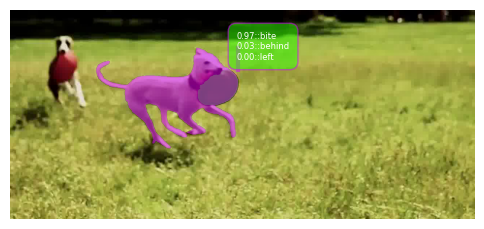

In [ ]:
# Reload the vis_utils
import importlib
import vis_utils

importlib.reload(vis_utils)
from vis_utils import get_binary_mask_one_image

fid = 0
get_binary_mask_one_image(batched_reshaped_raw_videos[fid], 
                          video_segments[fid], 
                          rel_pred_ls=formatted_batched_binary_probs[0][fid])